In [35]:
import numpy as np

a = 0b01101001
b = 0b01011001

n_bits = 8

def digit_list(a, n_bits):
    return np.array([int(i) for i in f'{a:0{n_bits}b}'])

def count1s(a, n_bits):
    return sum(digit_list(a, n_bits))

def inner_join(a, b, n_bits):
    inna = digit_list(a, n_bits)
    innb = digit_list(b, n_bits)
    return np.inner(inna, innb)

In [36]:
print(digit_list(a, 8))
print(digit_list(b, 8))

[0 1 1 0 1 0 0 1]
[0 1 0 1 1 0 0 1]


In [64]:
digs = 16

def make_1s_count(bin_digs):
    dig_arr = [0]*bin_digs
    for i in range(bin_digs):
        dig_arr[i] = sum(digit_list(i, bin_digs))
    return np.array(dig_arr)
    
make_1s_count(digs)

array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4])

In [49]:
p = [[1, 2, 3],
     [0, 1, 0],
     [1, 1, 2]]
p = np.array(p)

dig = [0, 1, 2]
dig = np.array(dig)


array([8, 1, 5])

In [58]:
sum(sum(p*dig))

14

In [79]:
import json
fname = 'results/qae_wangle_lat6_tr2_reps2_sca_p48_err0.03_min1s_hist300.json'
try:
    f = open(f'{fname}', 'r')
except OSError:
    print(f'Could not open/read file: {fname}n')
    sys.exit()
with f:
    history = json.load(f)
    print(f'New history file was read')

New history file was read


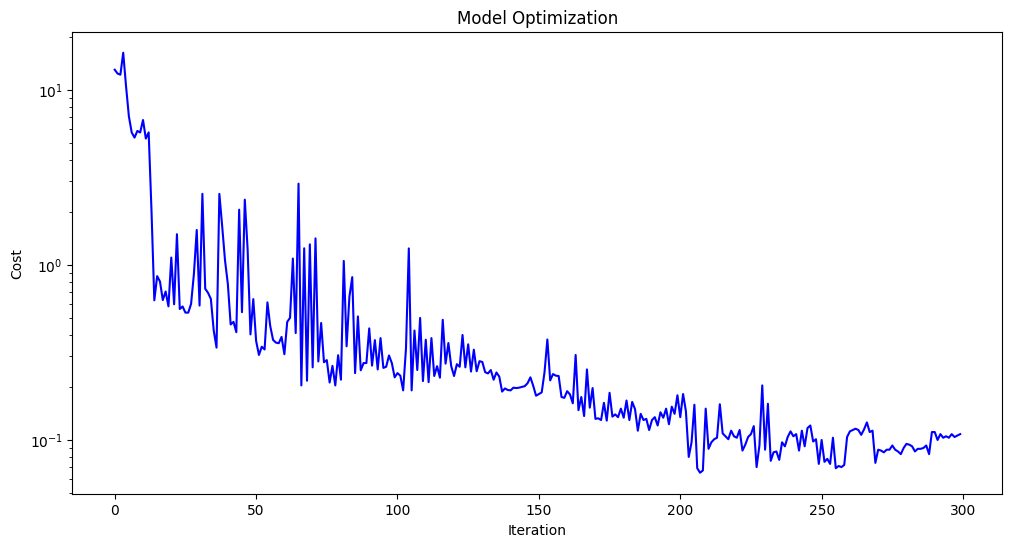

In [80]:
import matplotlib.pyplot as plt
# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title(f"Model Optimization")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.yscale("log") # {'asinh', 'function', 'functionlog', 'linear', 'log', 'logit', 'symlog'}


plt.plot(range(len(history)), history, color='blue')
plt.show()

In [4]:
import numpy as np
mylist = [3, 6, 2, 9, 23, 7, 8, 11, 2, 6]
np.argmin(mylist)

2

In [50]:
import random
random.sample(range(0, 100), 5)

[22, 81, 59, 92, 62]

In [196]:
import json
import time
import warnings

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
import numpy as np

from IPython.display import clear_output

set_loglevel("error")

# Exponential Moving Target used to smooth the lines 
def smooth_movtarg(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value        
    return smoothed

### Read JSON file
def read_json_file(fpath):
    data = []
    try:
        f = open(fpath, 'r')
    except OSError:
        print(f'Could not open/read file: {fpath}')
        sys.exit()
    with f:
        data = json.load(f)
    return data

### Plot cost
def cost_plot(objective_func_vals, rcParams=(8, 4), yscale='linear', 
                  backplot=False, smooth_weight=0.9):
    min_cost = min(objective_func_vals)
    iter = len(objective_func_vals)
    smooth_fn = smooth_movtarg(objective_func_vals, smooth_weight)
    x_of_min = np.argmin(objective_func_vals)
    clear_output(wait=True)
    plt.rcParams["figure.figsize"] = rcParams
    plt.title(f'Cost vs iteration '+('with smoothing ' if smooth_weight>0 else ' ')+
              f'(iter# {iter}, min cost={np.round(min_cost, 4)})')
    plt.xlabel(f'Iteration (min cost @ iter# {x_of_min})')
    plt.ylabel("Cost function value")
    plt.axvline(x=x_of_min, color="lightgray", linestyle='--')
    plt.yscale(yscale)
    if backplot:
        plt.plot(range(len(objective_func_vals)), objective_func_vals, color='lightgray')
    plt.plot(smooth_fn, color='black')
    plt.savefig('figures/train_perform_cost.eps', format='eps')
    plt.show()

### Plot MAE
def cost_mae_plot(mae_train_vals, mae_valid_vals, rcParams=(8, 4), yscale='linear', 
                  backplot=False, smooth_weight=0.9):
    # clear_output(wait=True)
    min_train_mae = min(mae_train_vals)
    min_valid_mae = min(mae_valid_vals)
    smooth_train = smooth_movtarg(mae_train_vals, smooth_weight)
    smooth_valid = smooth_movtarg(mae_valid_vals, smooth_weight)
    x_of_min = np.argmin(mae_valid_vals)
    iter = len(mae_train_vals)
    plt.rcParams["figure.figsize"] = rcParams
    plt.title(f'MAE vs iteration '+('with smoothing ' if smooth_weight>0 else ' ')+
              f'(iter# {iter}, '+
              f'min train MAE={np.round(min_train_mae, 4)}, '+
              f'valid MAE={np.round(min_valid_mae, 4)})')
    plt.xlabel(f'Iteration (min valid MAE @ iter# {x_of_min})')
    plt.ylabel("MAE")
    plt.axvline(x=x_of_min, color="lightgray", linestyle='--')
    plt.yscale(yscale)
    if backplot:
        plt.plot(range(len(mae_train_vals)), mae_train_vals, color='powderblue')
        plt.plot(range(len(mae_valid_vals)), mae_valid_vals, color='mistyrose')
    plt.plot(smooth_train, label='Training', color='blue')
    plt.plot(smooth_valid, label='Validation', color='red')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
      ncol=2, fancybox=True, shadow=True)
    plt.savefig('figures/train_perform_mae.eps', format='eps')
    plt.show()

In [197]:
hist = read_json_file('results/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_hist500.json')
tmae = read_json_file('results/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_tmae500.json')
vmae = read_json_file('results/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_vmae500.json')

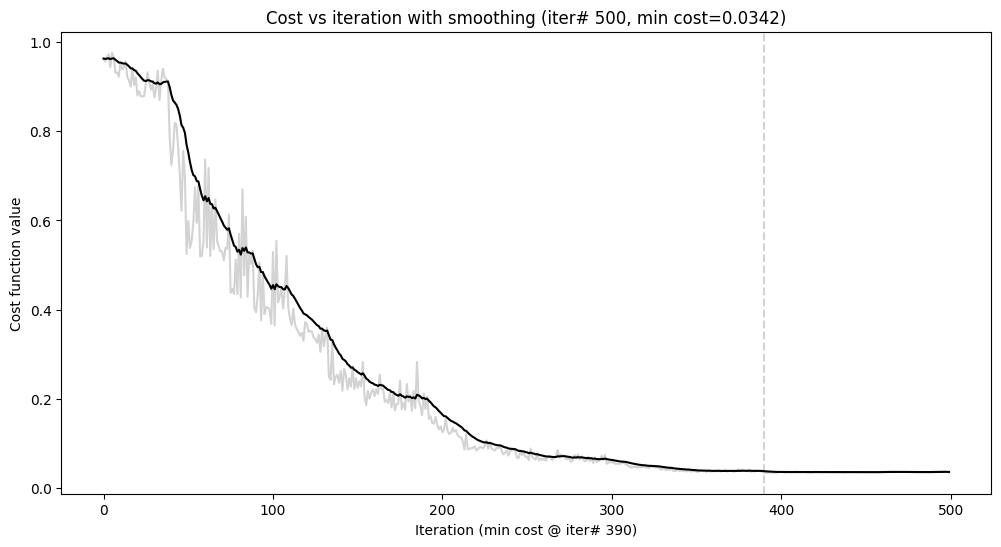

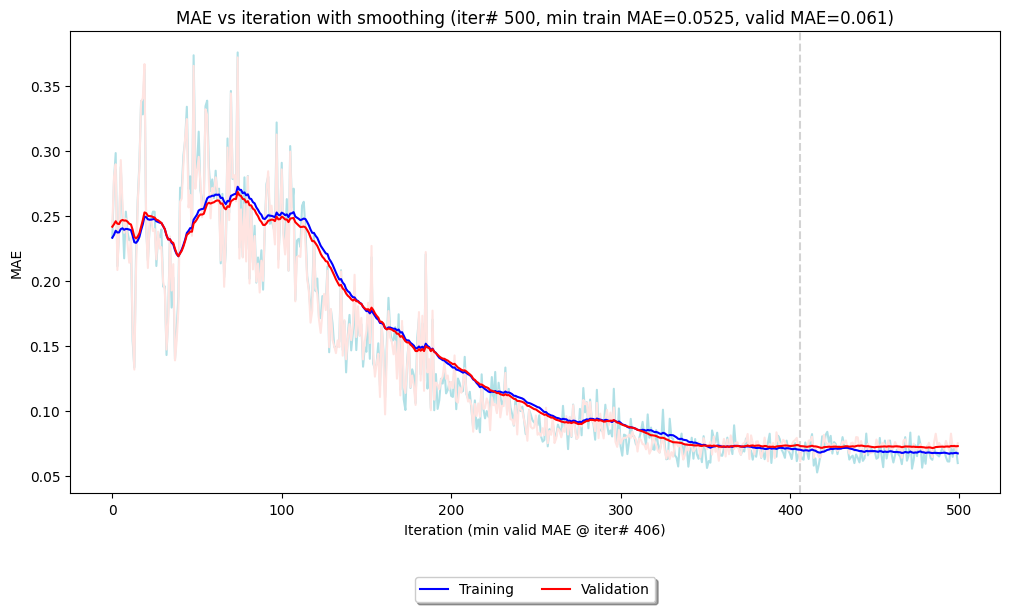

In [198]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

print()
cost_plot(hist, rcParams=(12, 6), smooth_weight=0.9, backplot=True)
print()
cost_mae_plot(tmae, vmae, rcParams=(12, 6), smooth_weight=0.95, backplot=True)
print()